In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 20

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -15
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 0  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 10 #10
NEGATIVE_REWARD_DIVIDE = 3 # kolikrat bude mensi times factor pri zaporne odmene

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}

osmdesat = 35

In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0.45  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9998
        
        self.learning_rate = 0.000815
        self.learning_rate_decay = 0.9999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        """
        model.add(CuDNNLSTM(units=76, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=50, return_sequences=True)) 
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))  
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > osmdesat * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0 #0.00001
    NEGATIVE_TIMES_REWARD = 0 #0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
            
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
                
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
More than 35 on candle 115
More than 35 on candle 206
More than 35 on candle 697


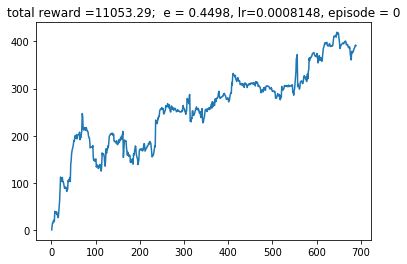

Waiting to train the whole dataset
action0:  263 
action1:  825 
action2:  892
DONE, lets roll!!
155.287
More than 35 on candle 504
More than 35 on candle 904


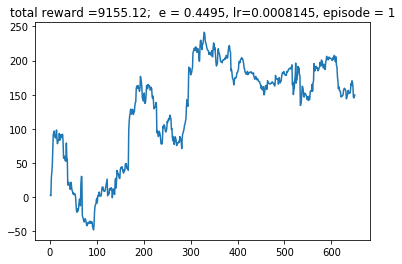

Waiting to train the whole dataset
action0:  306 
action1:  433 
action2:  1241
DONE, lets roll!!
180.862
More than 35 on candle 906
More than 35 on candle 1574


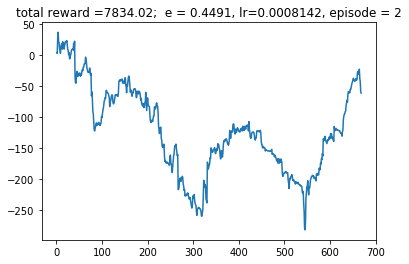

Waiting to train the whole dataset
action0:  305 
action1:  655 
action2:  1020
DONE, lets roll!!
85.017
More than 35 on candle 64


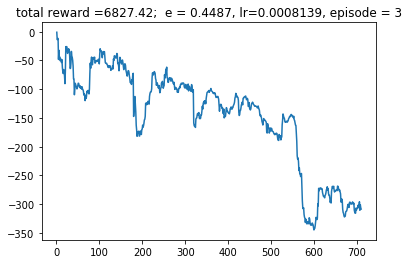

Waiting to train the whole dataset
action0:  293 
action1:  709 
action2:  978
DONE, lets roll!!
80.519
More than 35 on candle 210
More than 35 on candle 506
More than 35 on candle 694
More than 35 on candle 904


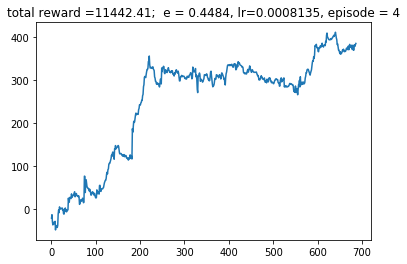

Waiting to train the whole dataset
action0:  291 
action1:  804 
action2:  885
DONE, lets roll!!
75.693
More than 35 on candle 208
More than 35 on candle 507
More than 35 on candle 904


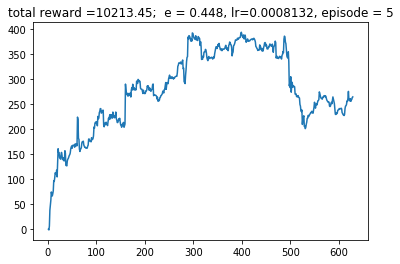

Waiting to train the whole dataset
action0:  275 
action1:  677 
action2:  1028
DONE, lets roll!!
75.49
More than 35 on candle 115


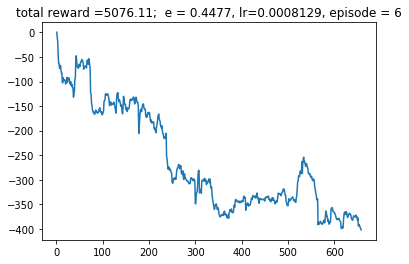

Waiting to train the whole dataset
action0:  309 
action1:  856 
action2:  815
DONE, lets roll!!
86.216
More than 35 on candle 508


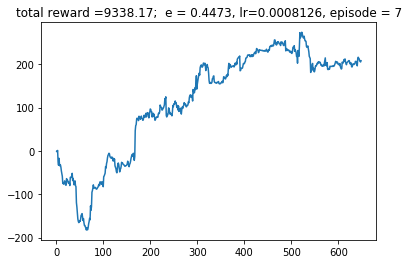

Waiting to train the whole dataset
action0:  275 
action1:  722 
action2:  983
DONE, lets roll!!
78.273
More than 35 on candle 212
More than 35 on candle 505


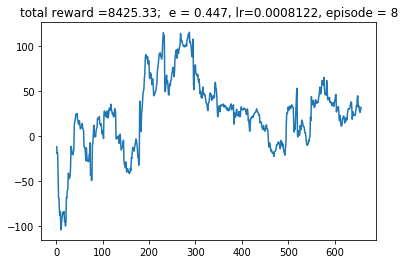

Waiting to train the whole dataset
action0:  281 
action1:  287 
action2:  1412
DONE, lets roll!!
81.358
More than 35 on candle 115
More than 35 on candle 207
More than 35 on candle 695


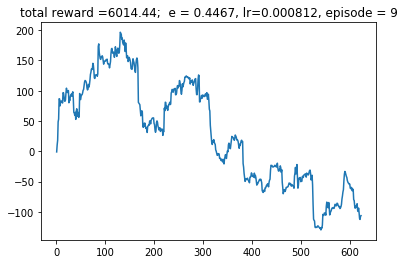

Waiting to train the whole dataset
action0:  308 
action1:  1103 
action2:  569
DONE, lets roll!!
79.74
More than 35 on candle 212


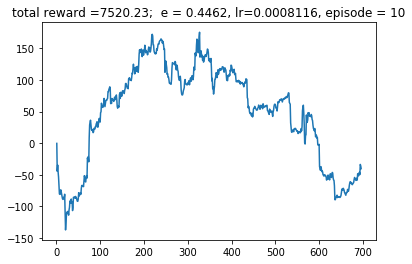

Waiting to train the whole dataset
action0:  283 
action1:  620 
action2:  1077
DONE, lets roll!!
75.841
More than 35 on candle 365
More than 35 on candle 907
More than 35 on candle 1190
More than 35 on candle 1585


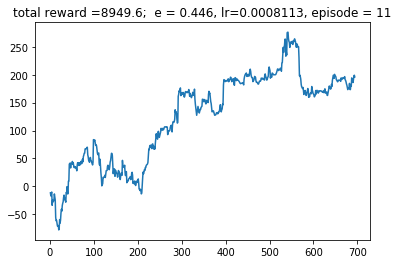

Waiting to train the whole dataset
action0:  313 
action1:  1149 
action2:  518
DONE, lets roll!!
74.804
More than 35 on candle 697
More than 35 on candle 1586


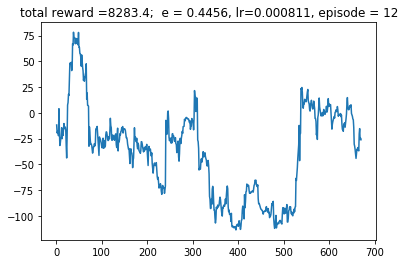

Waiting to train the whole dataset
action0:  300 
action1:  1070 
action2:  610
DONE, lets roll!!
75.707
More than 35 on candle 12
More than 35 on candle 215
More than 35 on candle 504


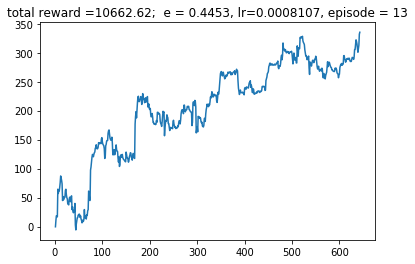

Waiting to train the whole dataset
action0:  248 
action1:  532 
action2:  1200
DONE, lets roll!!
74.254
More than 35 on candle 27
More than 35 on candle 215
More than 35 on candle 506


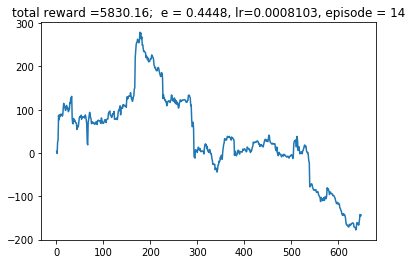

Waiting to train the whole dataset
action0:  311 
action1:  664 
action2:  1005
DONE, lets roll!!
76.621
More than 35 on candle 212
More than 35 on candle 504
More than 35 on candle 1587


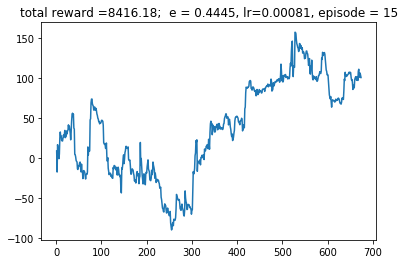

Waiting to train the whole dataset
action0:  285 
action1:  1355 
action2:  340
DONE, lets roll!!
75.46
More than 35 on candle 703
More than 35 on candle 906


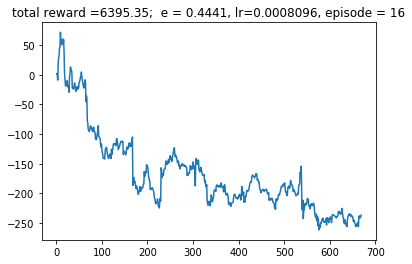

Waiting to train the whole dataset
action0:  296 
action1:  1024 
action2:  660
DONE, lets roll!!
74.62
More than 35 on candle 209
More than 35 on candle 508


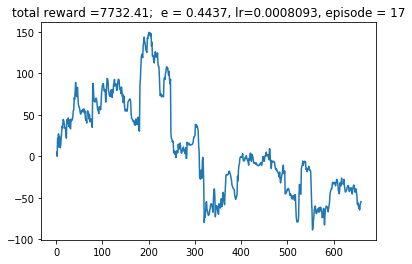

Waiting to train the whole dataset
action0:  281 
action1:  1068 
action2:  631
DONE, lets roll!!
74.211
More than 35 on candle 212
More than 35 on candle 1586


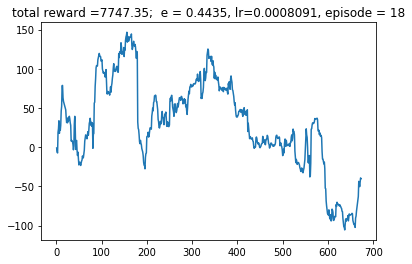

Waiting to train the whole dataset
action0:  268 
action1:  1140 
action2:  572
DONE, lets roll!!
74.187
More than 35 on candle 206
More than 35 on candle 908


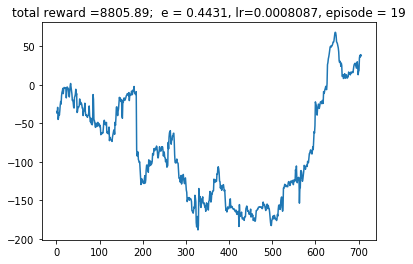

Waiting to train the whole dataset
action0:  291 
action1:  951 
action2:  738
DONE, lets roll!!
74.736
More than 35 on candle 117
More than 35 on candle 217
More than 35 on candle 504


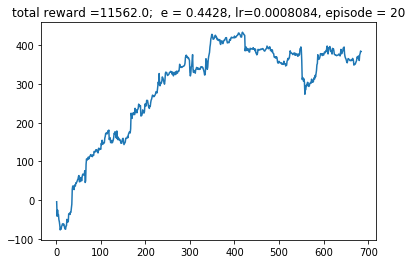

Waiting to train the whole dataset
action0:  293 
action1:  304 
action2:  1383
DONE, lets roll!!
74.247
More than 35 on candle 209
More than 35 on candle 505
More than 35 on candle 1674


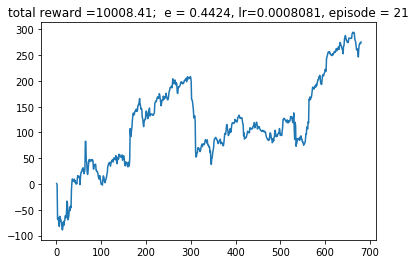

Waiting to train the whole dataset
action0:  296 
action1:  460 
action2:  1224
DONE, lets roll!!
75.717
More than 35 on candle 904


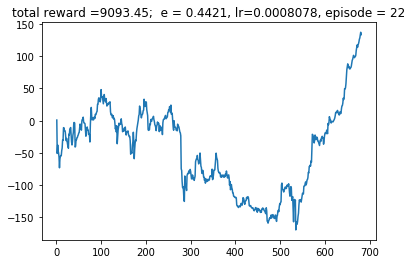

Waiting to train the whole dataset
action0:  297 
action1:  598 
action2:  1085
DONE, lets roll!!
74.978


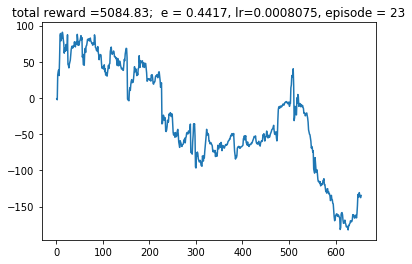

Waiting to train the whole dataset
action0:  290 
action1:  718 
action2:  972
DONE, lets roll!!
75.456
More than 35 on candle 703
More than 35 on candle 904
More than 35 on candle 1674


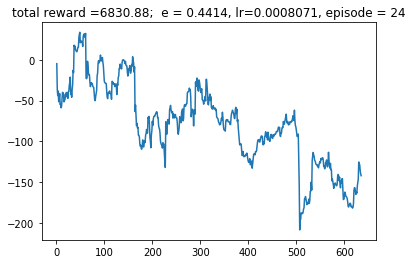

Waiting to train the whole dataset
action0:  280 
action1:  750 
action2:  950
DONE, lets roll!!
75.721
More than 35 on candle 504
More than 35 on candle 907
More than 35 on candle 1584


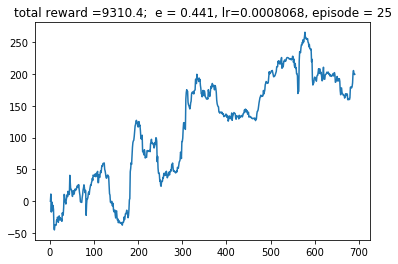

Waiting to train the whole dataset
action0:  320 
action1:  928 
action2:  732
DONE, lets roll!!
74.664
More than 35 on candle 16


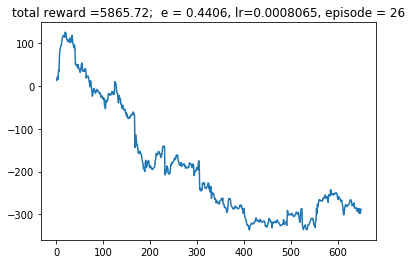

Waiting to train the whole dataset
action0:  318 
action1:  633 
action2:  1029
DONE, lets roll!!
74.7
More than 35 on candle 210


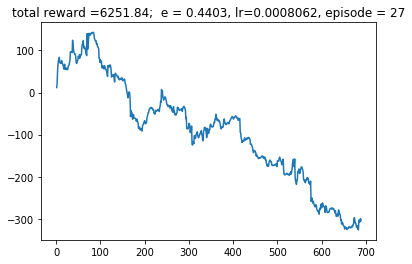

Waiting to train the whole dataset
action0:  280 
action1:  1130 
action2:  570
DONE, lets roll!!
73.391
More than 35 on candle 65
More than 35 on candle 916


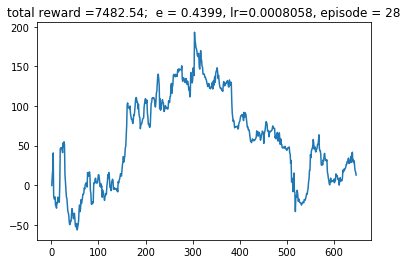

Waiting to train the whole dataset
action0:  267 
action1:  457 
action2:  1256
DONE, lets roll!!
74.905
More than 35 on candle 120
More than 35 on candle 206
More than 35 on candle 695
More than 35 on candle 1677


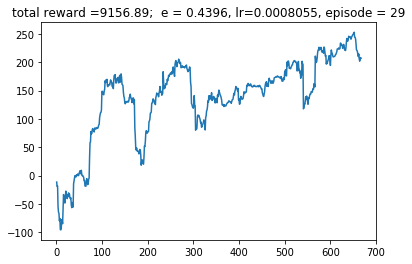

Waiting to train the whole dataset
action0:  293 
action1:  614 
action2:  1073
DONE, lets roll!!
74.257
More than 35 on candle 207
More than 35 on candle 504


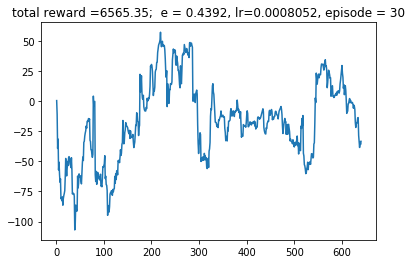

Waiting to train the whole dataset
action0:  259 
action1:  788 
action2:  933
DONE, lets roll!!
75.517
More than 35 on candle 115
More than 35 on candle 877
More than 35 on candle 904


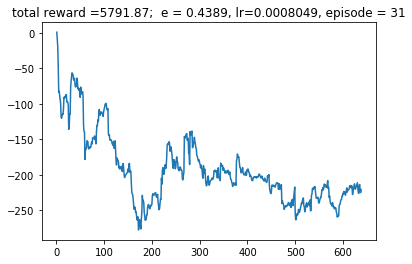

Waiting to train the whole dataset
action0:  292 
action1:  1140 
action2:  548
DONE, lets roll!!
75.359
More than 35 on candle 504


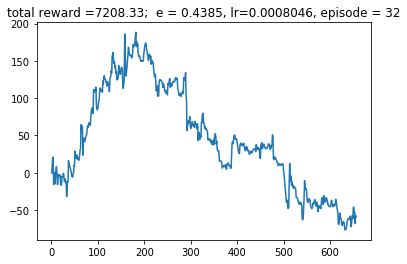

Waiting to train the whole dataset
action0:  313 
action1:  803 
action2:  864
DONE, lets roll!!
75.591
More than 35 on candle 213


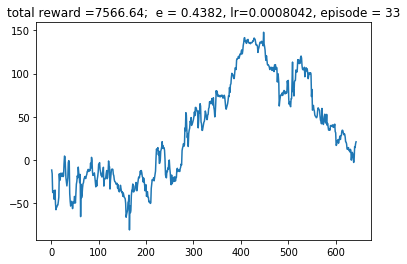

Waiting to train the whole dataset
action0:  288 
action1:  923 
action2:  769
DONE, lets roll!!
75.391
More than 35 on candle 123
More than 35 on candle 315
More than 35 on candle 505


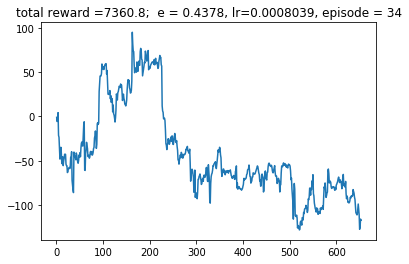

Waiting to train the whole dataset
action0:  289 
action1:  293 
action2:  1398
DONE, lets roll!!
75.22
More than 35 on candle 120
More than 35 on candle 212


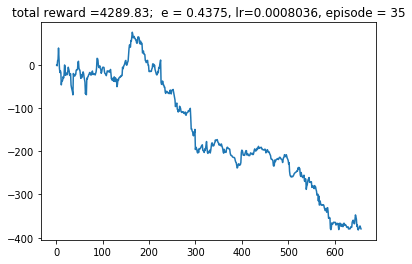

Waiting to train the whole dataset
action0:  292 
action1:  854 
action2:  834
DONE, lets roll!!
75.141
More than 35 on candle 905


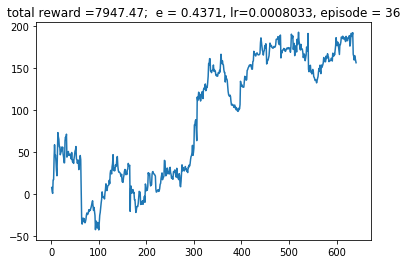

Waiting to train the whole dataset
action0:  272 
action1:  1192 
action2:  516
DONE, lets roll!!
74.882
More than 35 on candle 54
More than 35 on candle 695


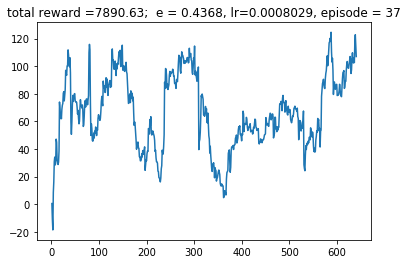

Waiting to train the whole dataset
action0:  290 
action1:  867 
action2:  823
DONE, lets roll!!
74.323
More than 35 on candle 23
More than 35 on candle 208


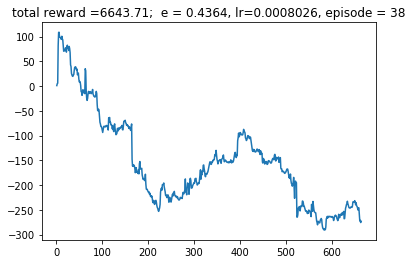

Waiting to train the whole dataset
action0:  268 
action1:  996 
action2:  716
DONE, lets roll!!
76.102
More than 35 on candle 207
More than 35 on candle 214
More than 35 on candle 877
More than 35 on candle 904


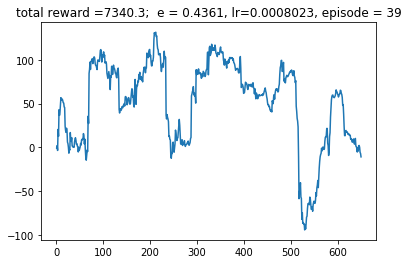

Waiting to train the whole dataset
action0:  256 
action1:  754 
action2:  970
DONE, lets roll!!
75.359
More than 35 on candle 1592


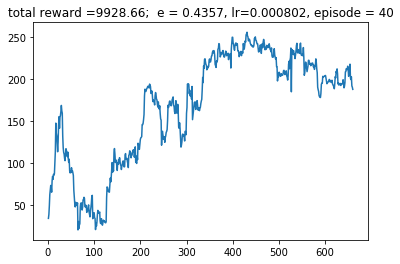

Waiting to train the whole dataset
action0:  279 
action1:  1411 
action2:  290
DONE, lets roll!!
76.785
More than 35 on candle 405


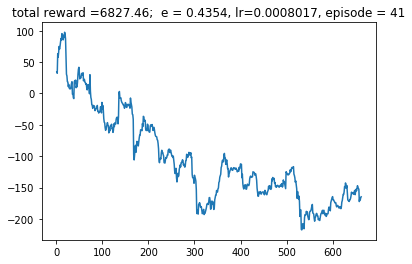

Waiting to train the whole dataset
action0:  282 
action1:  753 
action2:  945
DONE, lets roll!!
75.388
More than 35 on candle 207
More than 35 on candle 1587


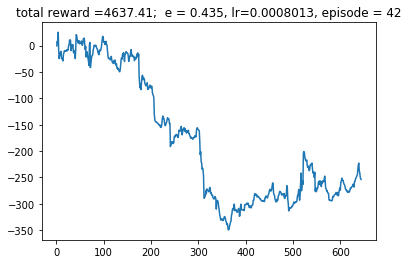

Waiting to train the whole dataset
action0:  268 
action1:  1061 
action2:  651
DONE, lets roll!!
74.258
More than 35 on candle 22
More than 35 on candle 697
More than 35 on candle 906
More than 35 on candle 1587


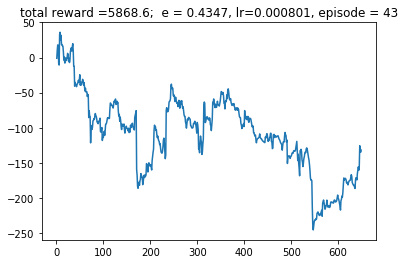

Waiting to train the whole dataset
action0:  275 
action1:  1417 
action2:  288
DONE, lets roll!!
74.997
More than 35 on candle 511
More than 35 on candle 695
More than 35 on candle 1674


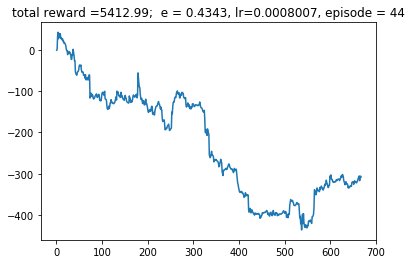

Waiting to train the whole dataset
action0:  296 
action1:  562 
action2:  1122
DONE, lets roll!!
75.502
More than 35 on candle 102
More than 35 on candle 208
More than 35 on candle 695
More than 35 on candle 904
More than 35 on candle 1574
More than 35 on candle 1678


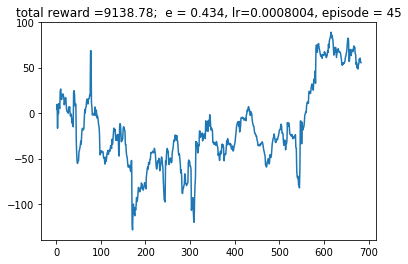

Waiting to train the whole dataset
action0:  333 
action1:  700 
action2:  947
DONE, lets roll!!
74.853
More than 35 on candle 212
More than 35 on candle 696
More than 35 on candle 906


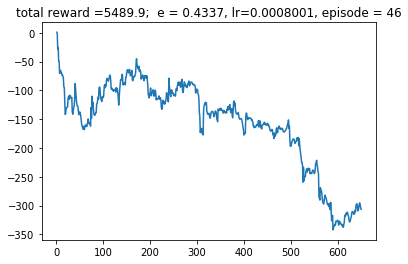

Waiting to train the whole dataset
action0:  279 
action1:  772 
action2:  929
DONE, lets roll!!
75.549
More than 35 on candle 215
More than 35 on candle 506
More than 35 on candle 877
More than 35 on candle 910


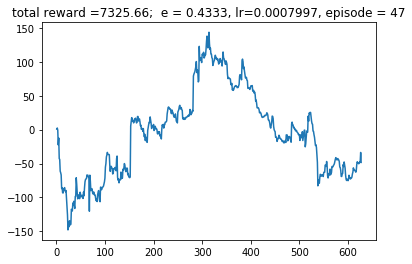

Waiting to train the whole dataset
action0:  246 
action1:  882 
action2:  852
DONE, lets roll!!
75.519
More than 35 on candle 697
More than 35 on candle 911


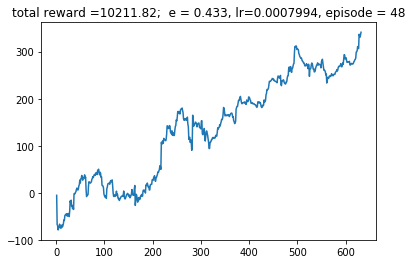

Waiting to train the whole dataset
action0:  281 
action1:  1024 
action2:  675
DONE, lets roll!!
74.787
More than 35 on candle 116
More than 35 on candle 405
More than 35 on candle 508


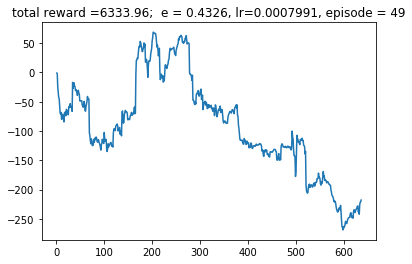

Waiting to train the whole dataset
action0:  275 
action1:  657 
action2:  1048
DONE, lets roll!!
75.639
More than 35 on candle 214
More than 35 on candle 1673


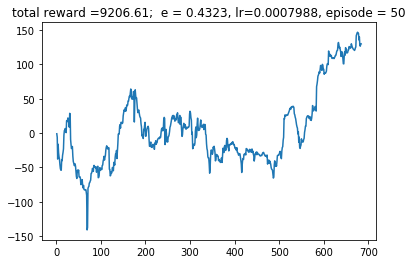

Waiting to train the whole dataset
action0:  289 
action1:  351 
action2:  1340
DONE, lets roll!!
75.553


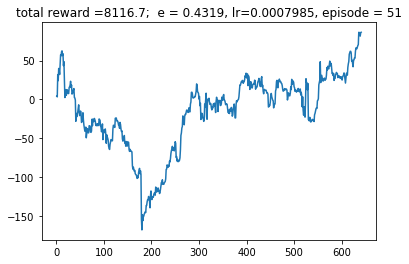

Waiting to train the whole dataset
action0:  264 
action1:  750 
action2:  966
DONE, lets roll!!
74.983
More than 35 on candle 60
More than 35 on candle 224
More than 35 on candle 504


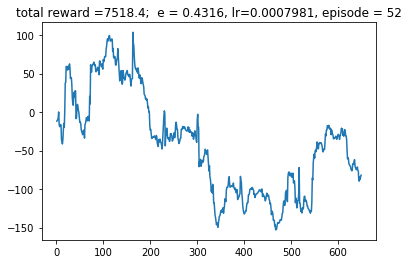

Waiting to train the whole dataset
action0:  283 
action1:  412 
action2:  1285
DONE, lets roll!!
74.932
More than 35 on candle 115


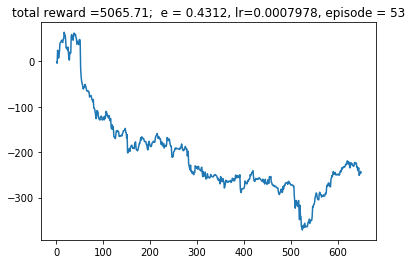

Waiting to train the whole dataset
action0:  274 
action1:  496 
action2:  1210
DONE, lets roll!!
76.502
More than 35 on candle 12
More than 35 on candle 115
More than 35 on candle 509


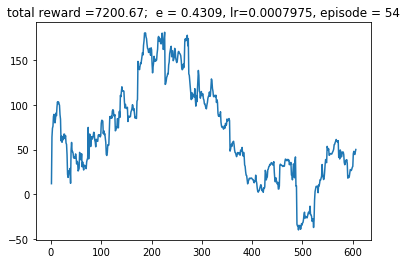

Waiting to train the whole dataset
action0:  275 
action1:  774 
action2:  931
DONE, lets roll!!
75.559
More than 35 on candle 115
More than 35 on candle 209
More than 35 on candle 504
More than 35 on candle 695


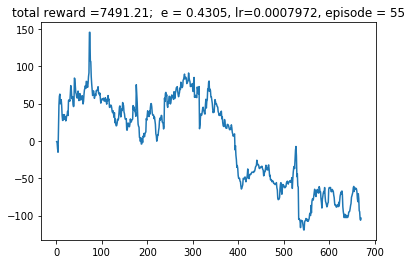

Waiting to train the whole dataset
action0:  285 
action1:  687 
action2:  1008
DONE, lets roll!!
76.27
More than 35 on candle 124
More than 35 on candle 1672


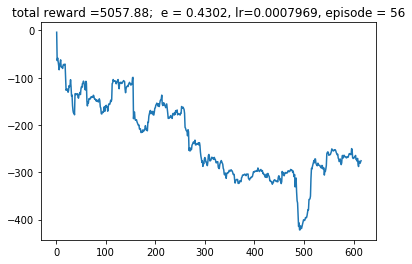

Waiting to train the whole dataset
action0:  266 
action1:  638 
action2:  1076
DONE, lets roll!!
75.975
More than 35 on candle 213
More than 35 on candle 505
More than 35 on candle 904


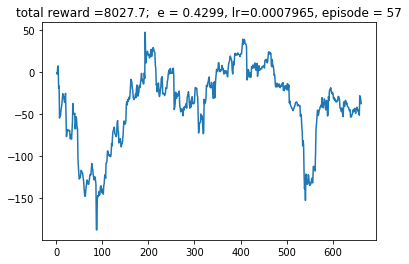

Waiting to train the whole dataset
action0:  293 
action1:  376 
action2:  1311
DONE, lets roll!!
76.009


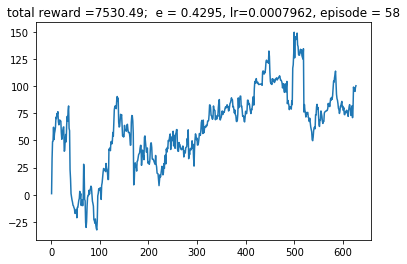

Waiting to train the whole dataset
action0:  309 
action1:  1348 
action2:  323
DONE, lets roll!!
75.425
More than 35 on candle 504
More than 35 on candle 1684


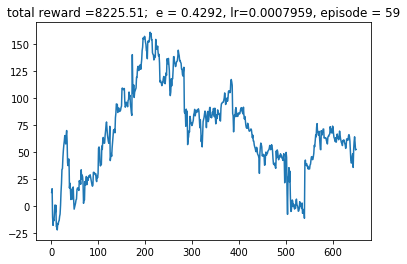

Waiting to train the whole dataset
action0:  280 
action1:  291 
action2:  1409
DONE, lets roll!!
75.112
More than 35 on candle 117
More than 35 on candle 216
More than 35 on candle 699


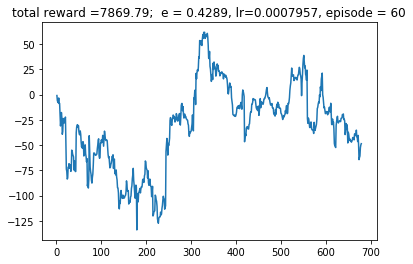

Waiting to train the whole dataset
action0:  287 
action1:  496 
action2:  1197
DONE, lets roll!!
74.515
More than 35 on candle 207


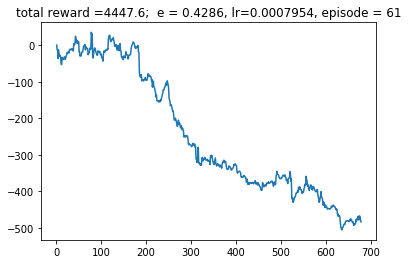

Waiting to train the whole dataset
action0:  282 
action1:  569 
action2:  1129
DONE, lets roll!!
74.965
More than 35 on candle 16
More than 35 on candle 1594


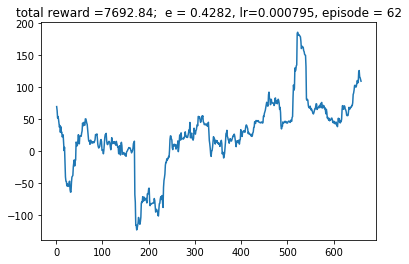

Waiting to train the whole dataset
action0:  284 
action1:  1135 
action2:  561
DONE, lets roll!!
76.255
More than 35 on candle 17
More than 35 on candle 115
More than 35 on candle 507


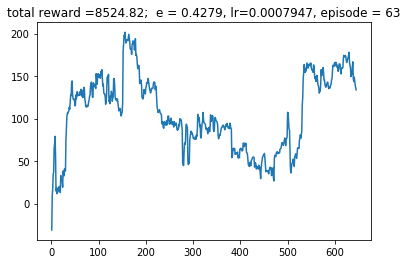

Waiting to train the whole dataset
action0:  293 
action1:  345 
action2:  1342
DONE, lets roll!!
75.023
More than 35 on candle 699


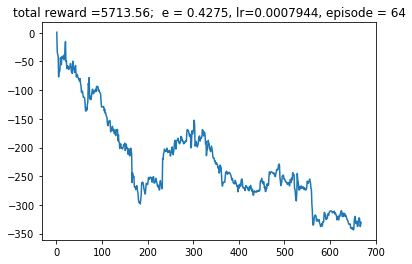

Waiting to train the whole dataset
action0:  289 
action1:  1103 
action2:  588
DONE, lets roll!!
74.484
More than 35 on candle 213
More than 35 on candle 504
More than 35 on candle 1574
More than 35 on candle 1673


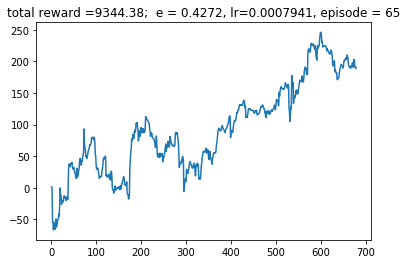

Waiting to train the whole dataset
action0:  281 
action1:  480 
action2:  1219
DONE, lets roll!!
77.677
More than 35 on candle 117
More than 35 on candle 505
More than 35 on candle 880
More than 35 on candle 909
More than 35 on candle 1192


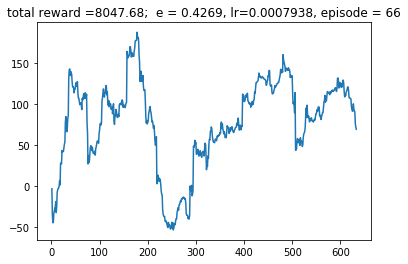

Waiting to train the whole dataset
action0:  273 
action1:  693 
action2:  1014
DONE, lets roll!!
87.802
More than 35 on candle 115
More than 35 on candle 216
More than 35 on candle 509
More than 35 on candle 695
More than 35 on candle 904


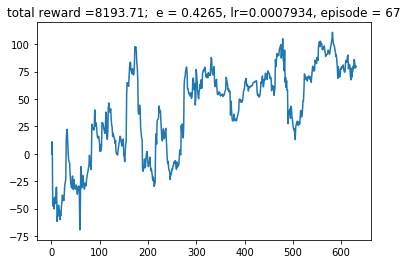

Waiting to train the whole dataset
action0:  282 
action1:  596 
action2:  1102
DONE, lets roll!!
86.08
More than 35 on candle 207
More than 35 on candle 212
More than 35 on candle 695
More than 35 on candle 904


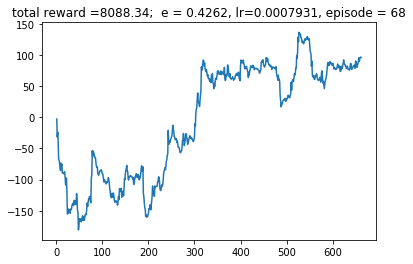

Waiting to train the whole dataset
action0:  288 
action1:  1401 
action2:  291
DONE, lets roll!!
86.618
More than 35 on candle 218
More than 35 on candle 505
More than 35 on candle 912


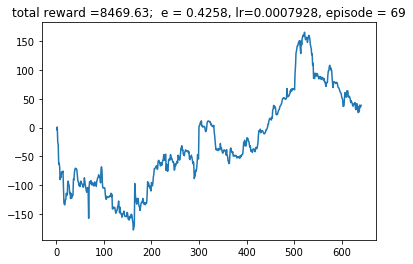

Waiting to train the whole dataset
action0:  275 
action1:  1084 
action2:  621
DONE, lets roll!!
86.588
More than 35 on candle 696


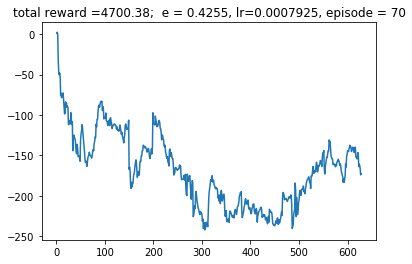

Waiting to train the whole dataset
action0:  288 
action1:  543 
action2:  1149
DONE, lets roll!!
88.251
More than 35 on candle 1573
More than 35 on candle 1585


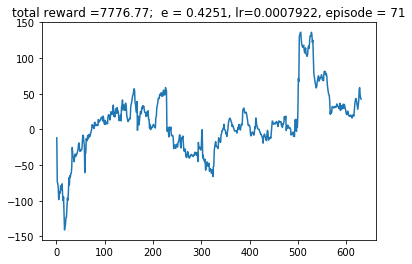

Waiting to train the whole dataset
action0:  263 
action1:  924 
action2:  793
DONE, lets roll!!
83.607
More than 35 on candle 214
More than 35 on candle 505


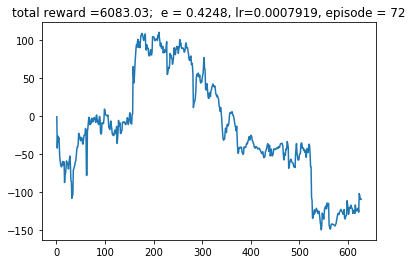

Waiting to train the whole dataset
action0:  297 
action1:  633 
action2:  1050
DONE, lets roll!!
81.851
More than 35 on candle 214
More than 35 on candle 876


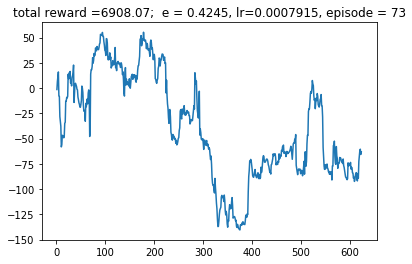

Waiting to train the whole dataset
action0:  287 
action1:  1024 
action2:  669
DONE, lets roll!!
83.624
More than 35 on candle 504
More than 35 on candle 695
More than 35 on candle 904
More than 35 on candle 1573
More than 35 on candle 1685


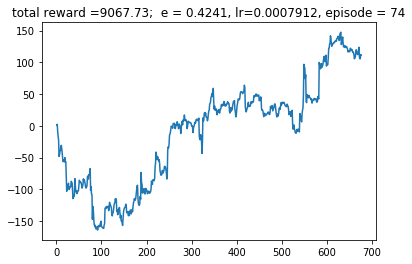

Waiting to train the whole dataset
action0:  293 
action1:  623 
action2:  1064
DONE, lets roll!!
83.22
More than 35 on candle 115
More than 35 on candle 212
More than 35 on candle 695


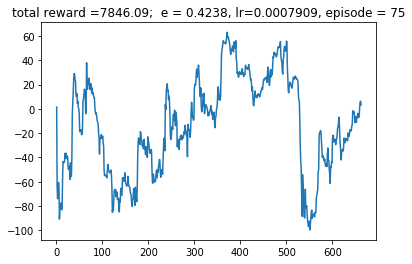

Waiting to train the whole dataset
action0:  270 
action1:  330 
action2:  1380
DONE, lets roll!!
82.432
More than 35 on candle 506
More than 35 on candle 1573


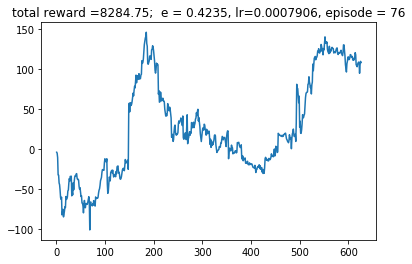

Waiting to train the whole dataset
action0:  275 
action1:  257 
action2:  1448
DONE, lets roll!!
83.898
More than 35 on candle 13
More than 35 on candle 118
More than 35 on candle 507
More than 35 on candle 907
More than 35 on candle 1196
More than 35 on candle 1586


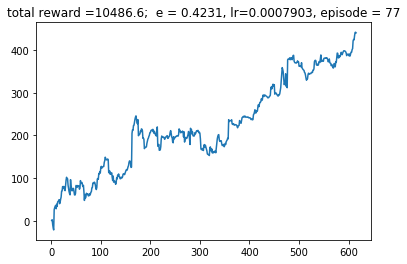

Waiting to train the whole dataset
action0:  272 
action1:  929 
action2:  779
DONE, lets roll!!
87.018
More than 35 on candle 20
More than 35 on candle 212
More than 35 on candle 508
More than 35 on candle 1671


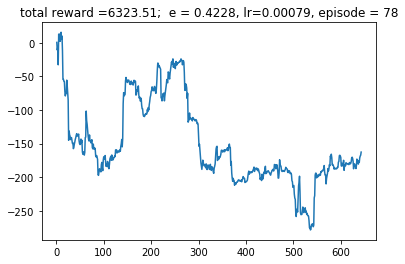

Waiting to train the whole dataset
action0:  292 
action1:  517 
action2:  1171
DONE, lets roll!!
89.146
More than 35 on candle 905


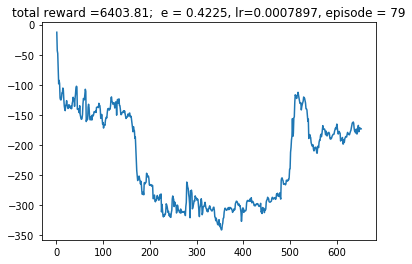

Waiting to train the whole dataset
action0:  291 
action1:  838 
action2:  851
DONE, lets roll!!
77.788
More than 35 on candle 214


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 128 #32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > osmdesat * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than {} on candle {}'.format(osmdesat, time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))